In [1]:
!pip install matplotlib
!pip install tensorflow==1.14
!pip install sklearn
!pip install joblib
!pip install --upgrade scikit-learn==0.20.3
!pip install keras==2.4.3

     |████████████████████████████████| 11.6 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 109.3 MB 32 kB/s  eta 0:00:01    |███████▏                        | 24.6 MB 5.4 MB/s eta 0:00:16
     |████████████████████████████████| 127 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 971 kB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 244 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 137 kB/s eta 0:00:01
     |████████████████████████████████| 488 kB 5.

In [2]:
from pyspark.sql import SparkSession

Chúng ta cần khai báo địa chỉ spark trong môi trường docker: "spark://spark-master:7077"
*Sau khi kết nối được với spark thông qua spark context, mở trang localhost:8080 sẽ thấy một job đang chạy*  

In [3]:
packages = ["org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.1",
            "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1"]
packages = ",".join(packages)

master = "spark://spark-master:7077"
appName = "Visualize"

spark = SparkSession.builder \
                    .master(master) \
                    .appName(appName) \
                    .config("spark.jars.packages", packages) \
                    .config("spark.executor.memory", "1024m") \
                    .config("spark.executor.core", "1") \
                    .getOrCreate()

spark

Chạy chương trình logger trong scripts/run-logger.sh để thực hiện streaming dữ liệu.
Dùng spark để nhận dữ liệu được streaming từ kafka tại df

In [4]:
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9093, kafka1:9093") \
  .option("subscribe", "USDEUR") \
  .option("startingOffsets", "earliest") \
  .load()

In [5]:
from pyspark.sql.functions import col, udf, split, mean
from pyspark.sql import Row, DataFrame
import numpy as np

Trích xuất các thông tin cần thiết từ dữ liệu và ghi vào bộ nhớ ram ở dạng temporary table

In [6]:
value = df.select(col("value").cast("string").alias("Value"))
# value.writeStream.format("memory").queryName("value").outputMode("update").start()

split_col = split(col("Value"), ",")
extract_task = value.select(split_col.getItem(0).cast("int").alias('id'),
                            split_col.getItem(1).cast("string").alias("Time"),
                            split_col.getItem(2).cast("float").alias("Open"),
                            split_col.getItem(3).cast("float").alias("High"),
                            split_col.getItem(4).cast("float").alias("Low"),
                            split_col.getItem(5).cast("float").alias("Close"),
                            split_col.getItem(6).cast("float").alias("Volume"))
                            
query = extract_task.writeStream \
                     .format("memory") \
                     .queryName("total") \
                     .outputMode("update") \
                     .start()

In [7]:
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |    total|       true|
+--------+---------+-----------+



Query quan sát dữ liệu với 20 rows đầu tiên


In [9]:
data = spark.sql("select * from total")
print(len(np.array(data.collect())))
data.show()

2001
+---+----------------+-------+-------+-------+-------+------+
| id|            Time|   Open|   High|    Low|  Close|Volume|
+---+----------------+-------+-------+-------+-------+------+
|  0|2020-10-27 04:03| 1.1821|1.18215|1.18208|1.18209| 419.0|
|  1|2020-10-27 04:04|1.18208|1.18214|1.18208|1.18214| 145.0|
|  2|2020-10-27 04:05|1.18214|1.18216|1.18212|1.18214| 176.0|
|  3|2020-10-27 04:07|1.18214|1.18225|1.18214|1.18224| 119.0|
|  4|2020-10-27 04:08|1.18223|1.18225|1.18221|1.18222| 255.0|
|  5|2020-10-27 04:09|1.18223|1.18226|1.18221|1.18224| 219.0|
|  6|2020-10-27 04:10|1.18225|1.18226|1.18224|1.18225| 156.0|
|  7|2020-10-27 04:11|1.18224|1.18225|1.18224|1.18224| 102.0|
|  8|2020-10-27 04:12|1.18225|1.18235|1.18221|1.18234| 641.0|
|  9|2020-10-27 04:13|1.18234|1.18235|1.18226|1.18229| 450.0|
| 10|2020-10-27 04:14|1.18228|1.18231|1.18227|1.18229| 582.0|
| 11|2020-10-27 04:15|1.18231|1.18231|1.18228|1.18229| 306.0|
| 12|2020-10-27 04:16| 1.1823|1.18233|1.18228|1.18233| 379.0|
| 1

Sử dụng matplotlib để visualize dữ liệu dạng streaming, những dữ liệu mới sẽ được tự động visualize lên.

In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(20,10), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

data_visua = collections.defaultdict(list)
data_visua['USD_EUR'] = list(np.array(data.select("Close").collect())[2000])
# data1['fa'] = list(np.array(data.select("Close").collect())[:,0] + 0.01)
while(1):
    live_plot(data_visua)
    if(data_visua['USD_EUR'][-1] != np.array(data.select("Close").collect())[-1][0]) :
        data_visua['USD_EUR'].append(np.array(data.select("Close").collect())[-1][0])
        live_plot(data_visua)

### Build model LSTM
Xây dựng một model đơn giản sử dụng LSTM, predict streaming data


In [10]:
from sklearn.preprocessing import MinMaxScaler
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [11]:
# data = spark.sql("select * from total")
dataset = np.array(data.select("Close").collect())

scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
#Training and test sets
train = dataset[:1500]
test = dataset[1500:]

def get_data(data, look_back):
    datax, datay = [],[]
    for i in range(len(data)-look_back-1):
        datax.append(data[i:(i+look_back),0])
        datay.append(data[i+look_back,0])
    return np.array(datax) , np.array(datay)
look_back = 1

x_train , y_train = get_data(train, look_back)
x_test , y_test = get_data(test,look_back)


#Processing train and test sets for LSTM model
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1498, 1, 1)
(1498,)
(499, 1, 1)
(499,)


In [12]:
#Defining the LSTM model

n_features=x_train.shape[1]
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(1,1)))
model.add(Dense(n_features))

model.summary()
model.compile(optimizer='adam', loss = 'mse')
#Compiling
model.compile(optimizer='adam', loss = 'mse')

#Training
model.fit(x_train,y_train, epochs = 5, batch_size=1)
model.save("model.h5")
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
1498/1498 [==============================] - 5s 3ms/sample - loss: 0.0305
Epoch 2/5
1498/1498 [==============================] - 4s 3ms/sample - loss: 2.4854e-04
Epoch 3/5
1498/1498 [==============================] - 4s 2ms/sample - loss: 1.2351e-04
Epoch 4/5
1498/1498 [=====================

['scaler.save']

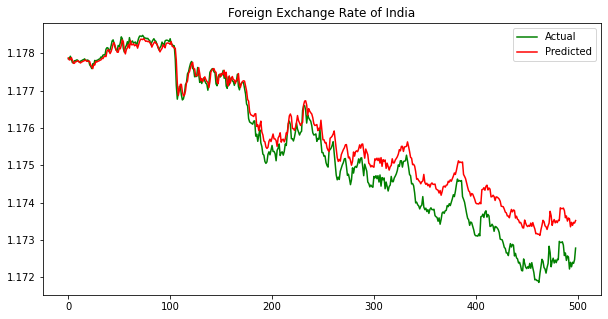

In [16]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = np.array(y_test).reshape(-1,1)
y_test = scaler.inverse_transform(y_test)

#Visualizing the results
plt.figure(figsize=(10,5))
plt.title('Foreign Exchange Rate of India')
plt.plot(y_test , label = 'Actual', color = 'g')
plt.plot(y_pred , label = 'Predicted', color = 'r')
plt.legend()

### Visualize data and model predict


In [17]:
data = spark.sql("select * from total")
print(len(np.array(data.collect())))

2013


Data sẽ được đọc theo dạng streaming, mỗi khi data tới, biểu đồ sẽ tự động vẽ ra data và pred tương ứng với nó bằng matplotlib

In [ ]:
num_start = 2000
data_visua = collections.defaultdict(list)
rt_x_test = np.array(data.select("Close").collect())[num_start:]
scaler.transform(rt_x_test)
rt_x_test = rt_x_test.reshape(rt_x_test.shape[0], rt_x_test.shape[1], 1)
rt_y_test = scaler.inverse_transform(model.predict(rt_x_test))

data_visua['USD_EUR'] = list(np.array(data.select("Close").collect())[num_start+1:, 0])
data_visua['USD_EUR_pred'] = list(rt_y_test[:-1, 0])

while(1):
    live_plot(data_visua)
    if(data_visua['USD_EUR'][-1] != np.array(data.select("Close").collect())[-1, 0]) :
        x = data_visua['USD_EUR'][-1].reshape(1, 1)
        data_visua['USD_EUR'].append(np.array(data.select("Close").collect())[-1, 0])
        
        x = scaler.transform(x)
        x = x.reshape(1, 1, 1)
        pred = scaler.inverse_transform(model.predict(x))
        data_visua['USD_EUR_pred'].append(pred)
        live_plot(data_visua)
